# Exploratory Analysis

In [1]:
import time

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.manifold import TSNE

In [2]:
print(os.listdir('../input'))

['download_data.py', 'kmnist-test-imgs.npz', 'kmnist-test-labels.npz', 'kmnist-train-imgs.npz', 'kmnist-train-labels.npz']


Note that .npz files are stored as a dictionary, therefore we need to access its keys to retrieve the numpy array. In this case, it is `'arr_0'`.

In [3]:
train_images = np.load('../input/kmnist-train-imgs.npz')['arr_0']
test_images = np.load('../input/kmnist-test-imgs.npz')['arr_0']
train_labels = np.load('../input/kmnist-train-labels.npz')['arr_0']
test_labels = np.load('../input/kmnist-test-labels.npz')['arr_0']

### Preprocess the Data

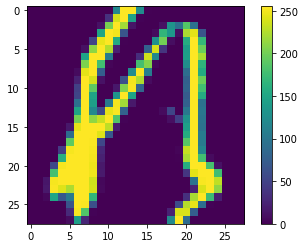

In [4]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

We first scale the dataset.

In [5]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Display some sample images to get an idea of the distribution

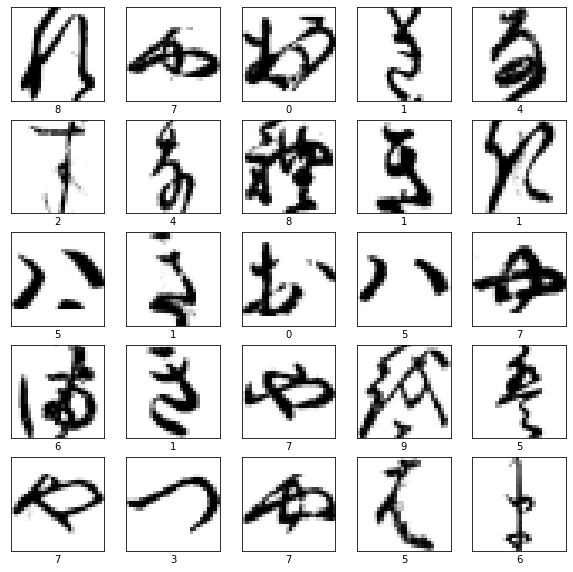

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

### Visualization

Let's visualize the dataset using T-SNE. The algorithm will take a minute or two to run.

In [7]:
# Sample from the training set
sample_size = 8000

np.random.seed(2018)
idx = np.random.choice(60000, size=sample_size, replace=False)
train_sample = train_images.reshape(60000, -1)[idx, :]
label_sample = train_labels[idx]

# Generate 2D embedding with TSNE
embeddings = TSNE(verbose=2).fit_transform(train_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.699s...
[t-SNE] Computed neighbors for 8000 samples in 90.587s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 2.647760
[t-SNE] Computed conditional probabilities in 0.458s
[t-SNE] Iteration 50: error = 93.4076080, gradient norm = 0.0006126 (50 iterations in 7.481s)
[t-SNE] Iteration 100: error = 87.1779404, gradient norm = 0.0039828 (50 iterations in 7.482s)
[t-SNE] Iteration 150: error = 86.3974915, gradient norm = 

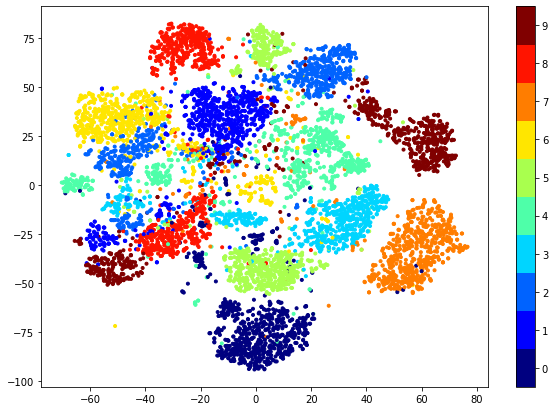

In [8]:
# Visualize TSNE embedding
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

plt.figure(figsize=(10,7))
plt.scatter(vis_x, vis_y, c=label_sample, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

# Classification Models

In [9]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

from sklearn.neighbors import KNeighborsClassifier

In [10]:
X_train_flat = train_images.reshape(60000, -1)
X_test_flat = test_images.reshape(10000,-1)

# Keras inputs
x_train = np.expand_dims(train_images, axis=-1)
x_test = np.expand_dims(test_images, axis=-1)
y_train = keras.utils.to_categorical(train_labels)
y_test = keras.utils.to_categorical(test_labels)

### k-NN Baselines
Warning: This is very slow! Skip this if you want to directly try out the CNN model.

In [11]:
neigh = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
neigh.fit(X_train_flat, train_labels)
print("k-NN Test Accuracy:", neigh.score(X_test_flat, test_labels))

k-NN Test Accuracy: 0.9149


This is very close to the reported accuracy of 91.56% by Clanuwat et al.

### Simple CNN with Keras

In [12]:
img_rows, img_cols = 28, 28
batch_size = 128
num_classes = 10
epochs = 12

In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 12s 200us/sample - loss: 2.2889 - acc: 0.1288 - val_loss: 2.2698 - val_acc: 0.2255
Epoch 2/12
60000/60000 [==============================] - 9s 149us/sample - loss: 2.2441 - acc: 0.2136 - val_loss: 2.2321 - val_acc: 0.3547
Epoch 3/12
60000/60000 [==============================] - 8s 141us/sample - loss: 2.1860 - acc: 0.3015 - val_loss: 2.1788 - val_acc: 0.4216
Epoch 4/12
60000/60000 [==============================] - 9s 142us/sample - loss: 2.1019 - acc: 0.3796 - val_loss: 2.1061 - val_acc: 0.4478
Epoch 5/12
60000/60000 [==============================] - 9s 142us/sample - loss: 1.9926 - acc: 0.4353 - val_loss: 2.0149 - val_acc: 0.4646
Epoch 6/12
60000/60000 [==============================] - 9s 146us/sample - loss: 1.8648 - acc: 0.4748 - val_loss: 1.9116 - val_acc: 0.4908
Epoch 7/12
60000/60000 [==============================] - 9s 150us/sample - loss: 1.7299 - acc: 0.5074 - val_

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4894577182769775
Test accuracy: 0.5518


Again, the accuracy is very close to the 95.12% reported on the paper.

## References

1. Deep Learning for Classical Japanese Literature. Tarin Clanuwat et al. arXiv:1812.01718

### Links
* Original Paper repository: https://github.com/rois-codh/kmnist
* Multicore TSNE: https://github.com/DmitryUlyanov/Multicore-TSNE
* Inspiration: https://www.tensorflow.org/tutorials/keras/basic_classification